In [1]:
import pandas as pd
import anndata as ad

In [2]:
path_to_bootstrap_merged_file = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_run_feb28/master_melted_df.csv.gz"
melted_results = pd.read_csv(path_to_bootstrap_merged_file,index_col=0)

In [3]:
melted_results['exp_type'] = melted_results.organism_part.str.split("_").str.get(0)
melted_results['tissue'] = melted_results.organism_part.str.split("_").str.get(1)

In [4]:
# Load GO term cell type affiliation data
path_to_curated_gos = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/bp_curated_annotations.tsv"
curated_gos = pd.read_csv(path_to_curated_gos, sep = "\t")

In [5]:
def create_new_column(df):
    """
    Create a new column based on conditions in existing columns.

    Parameters:
    - df: pandas DataFrame

    Returns:
    - pandas DataFrame with a new column "NewColumn"
    """
    # Create a new column using conditions
    meta = df.apply(lambda row: 'Brain' if row['BrainAffiliated'] == 'T' else ('PBMC' if row['PBMCAffiliated'] == 'T' else "Neither"), axis=1)

    return meta

curated_gos['meta'] = create_new_column(curated_gos)

curated_gos = curated_gos.loc[:,['id', 'meta']]

In [6]:
results = melted_results.groupby(['index', 'variance', 'exp_type', 'tissue'])['auc'].mean().reset_index()

In [7]:
merged = results.merge(curated_gos, left_on='index', right_on='id')

# Gross between different tissues

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


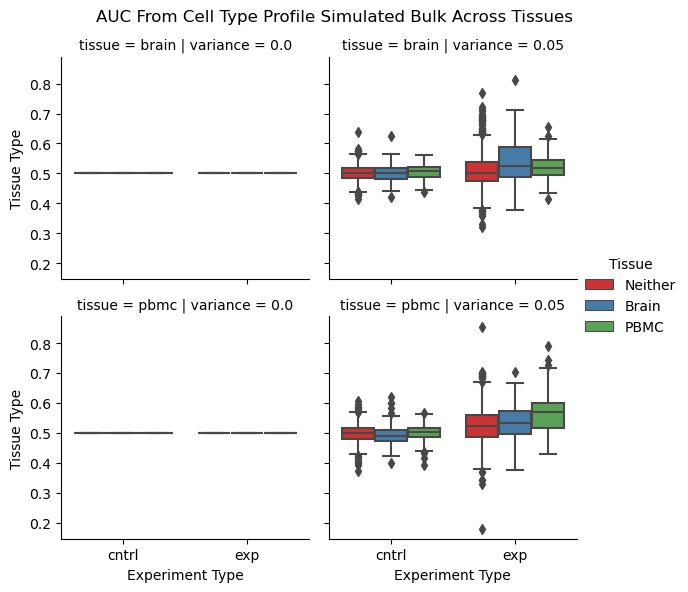

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a FacetGrid with seaborn
g = sns.FacetGrid(merged, row="tissue", col = 'variance')


# Draw a boxplot in each facet
g.map(sns.boxplot, 'exp_type' ,'auc', 'meta', palette='Set1')
# Add labels to the facets
g.set_axis_labels("Experiment Type", "Tissue Type")
g.add_legend(title="Tissue")
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('AUC From Cell Type Profile Simulated Bulk Across Tissues')
# Show the plot
plt.show()

# Save the plot
g.savefig('CTProfileBulkResults.png')


# Get P-values with Kruskal Wallis - (manu witney signed but with anova more groups)

In [18]:
merged_005 = merged[merged.loc[:,'variance'] == 0.05]

In [19]:
merged_005

,index,variance,exp_type,tissue,auc,id,meta
4,GO:0000045,0.05,cntrl,brain,0.493447,GO:0000045,Neither
5,GO:0000045,0.05,cntrl,pbmc,0.479040,GO:0000045,Neither
6,GO:0000045,0.05,exp,brain,0.549934,GO:0000045,Neither
7,GO:0000045,0.05,exp,pbmc,0.558939,GO:0000045,Neither
12,GO:0000070,0.05,cntrl,brain,0.500129,GO:0000070,Neither
...,...,...,...,...,...,...,...
11159,GO:2001243,0.05,exp,pbmc,0.482432,GO:2001243,Neither
11164,GO:2001244,0.05,cntrl,brain,0.466322,GO:2001244,Neither
11165,GO:2001244,0.05,cntrl,pbmc,0.499054,GO:2001244,Neither
11166,GO:2001244,0.05,exp,brain,0.490557,GO:2001244,Neither


In [25]:
# TODO

import scipy.stats as stats
# Specify the columns for the Kruskal-Wallis test
columns_for_kruskal = ["variance", "exp_type", "id", "meta",'tissue']

# Perform Kruskal-Wallis test
statistic, p_value = stats.kruskal(*[merged_005[merged_005[col]]['auc'] for col in columns_for_kruskal])


KeyError: "None of [Index([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,\n       ...\n       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],\n      dtype='float64', length=5584)] are in the [columns]"

# NEXT

If i get ct profiles, there is no difference in between one cell. All excititory neurons are the same.

For functions that are mostly ubiquitous. I expect to see very little performance, because its likely that the genes that do these ubiquitous processes are always on, anmd likely just the same

But for functions that are CT specific. I'm pretty sure I expect that if I add a bunch of those CT, then I add a bunch of those CT Markers, and then samples will strongly correlate that have those CT Markers

# Get GO Terms affiliated with Brain

In [36]:
# Load GO term cell type affiliation data
path_to_curated_gos = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/bp_curated_annotations.tsv"
curated_gos = pd.read_csv(path_to_curated_gos, sep = "\t")
go_annot = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/data/processing/bp_annotations_withGeneData_qc_annotations.csv")

In [37]:
# First get a list of all of the GOs related to brains
lo_brain_related_gos = curated_gos[curated_gos.loc[:,'BrainAffiliated'] == "T"].id

In [38]:
# Now get all of the genes in these brain GO terms
go_annot_brain = go_annot[go_annot.loc[:,"GO ID"].isin(lo_brain_related_gos)]
lo_brain_related_genes = go_annot_brain.ensembl_gene_id.unique()

In [39]:
# Load the experimental or control simulated bulk sample
import pandas as pd
con_path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_run2/1/simulations/0.05/cntrl_brain_sc_with_metadata_pc_cell_type_profiles.csv/cntrl_brain_sc_with_metadata_pc_cell_type_profiles_.csv.gz"
exp_path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_run2/1/simulations/0.05/exp_brain_sc_with_metadata_pc_cell_type_profiles.csv/exp_brain_sc_with_metadata_pc_cell_type_profiles_.csv.gz"
sim_bulk = pd.read_csv(exp_path, index_col=0)

In [40]:
# get correlations
sim_bulk_corr = sim_bulk.T.corr()

# Make Complex Heatmap


In [41]:
import os,sys
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
# plt.rcParams['figure.dpi'] = 100
# plt.rcParams['savefig.dpi']=300
# plt.rcParams['font.family']='sans serif' #please remove this line if font is not installed
# plt.rcParams['font.sans-serif']='Arial' # please remove this line if Arial font is not installed
# plt.rcParams['pdf.fonttype']=42
# sys.path.append(os.path.expanduser("~/Projects/Github/PyComplexHeatmap/"))
import PyComplexHeatmap as pch
import pandas as pd

In [42]:
# First, make a df of the annotations that I need.
df_annotations = pd.DataFrame(index=sim_bulk_corr.index, data={"brain": sim_bulk_corr.index.isin(lo_brain_related_genes)})
df_annotations['brain'] = df_annotations['brain'].replace({True: 'T', False: 'F'})
df_annotations = df_annotations.sort_values('brain', ascending=False)

In [43]:
df_annotations

,brain
ENSG00000104375,T
ENSG00000198026,T
ENSG00000182957,T
ENSG00000182963,T
ENSG00000198049,T
...,...
ENSG00000134109,F
ENSG00000134146,F
ENSG00000134152,F
ENSG00000134153,F


AttributeError: QuadMesh.set() got an unexpected keyword argument 'method'

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

<Figure size 640x480 with 0 Axes>

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

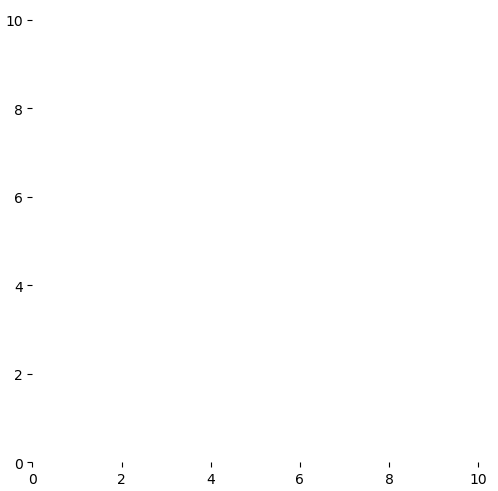

In [133]:
plt.clf()
plt.figure(figsize=(6, 6))

cm = pch.ClusterMapPlotter(data=sim_bulk_corr.iloc[0:10,0:10],
                           top_annotation = col_ha,
                           right_annotation = row_ha,
                            col_cluster=True,
                            row_cluster=True, # cluster rows and dols
                            label='Correlation', # Legend Name
                            # row_dendrogram=True,
                            show_rownames=False,show_colnames=False, # Do not show row or col names
                            cmap='RdBu_r', # set colors
                            verbose=0,
                            legend_gap = 5# distance legend
                            #xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'} # rotate x axis marks
                            )

plt.savefig("example0.png", bbox_inches='tight')
plt.show()


findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

Starting plotting HeatmapAnnotations


findfont: Generic family 'sans serif' not found because none of the following families were found: Arial


findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

<Figure size 640x480 with 0 Axes>

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

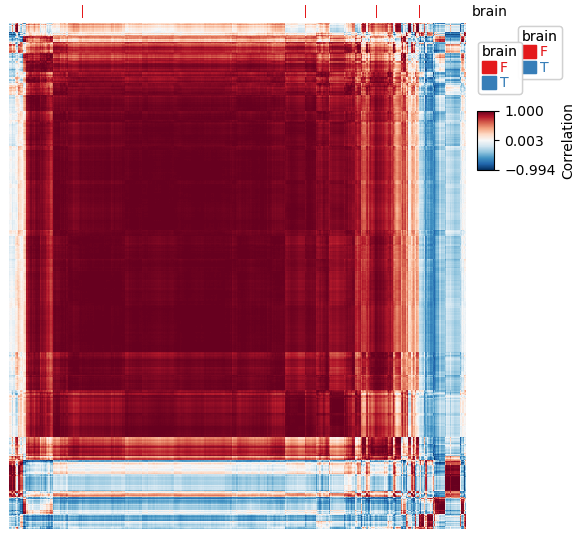

In [139]:
import fastcluster

# custom column linkage
linkage = fastcluster.linkage(sim_bulk_corr.iloc[0:1000,0:1000], method='weighted', metric='canberra')

plt.clf()
plt.figure(figsize=(6, 6))

cm = pch.ClusterMapPlotter(data=sim_bulk_corr.iloc[0:1000,0:1000],
                           top_annotation = col_ha,
                            col_cluster=True,
                            row_cluster=True, # cluster rows and dols
                            label='Correlation', # Legend Name
                            # row_dendrogram=True,
                            show_rownames=False,show_colnames=False, # Do not show row or col names
                            cmap='RdBu_r', # set colors
                            verbose=0,
                            legend_gap = 5, # distance legend
                            #xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'} # rotate x axis marks
                            col_dendrogram_kws=dict(linkage=linkage)
                            )

plt.savefig("example0.png", bbox_inches='tight')
plt.show()


In [17]:
import pandas as pd
con_path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_run2/1/simulations/0.05/cntrl_brain_sc_with_metadata_pc_cell_type_profiles.csv/cntrl_brain_sc_with_metadata_pc_cell_type_profiles_.csv.gz"
exp_path = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_run2/1/simulations/0.05/exp_brain_sc_with_metadata_pc_cell_type_profiles.csv/exp_brain_sc_with_metadata_pc_cell_type_profiles_.csv.gz"
df = pd.read_csv(exp_path, index_col=0)

# Load GO term cell type affiliation data
path_to_curated_gos = "/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/bp_curated_annotations.tsv"
curated_gos = pd.read_csv(path_to_curated_gos, sep = "\t")
# /space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulationOneProfile/data/boot_run2/1/simulations/0.05/cntrl_brain_sc_with_metadata_pc_cell_type_profiles.csv/cntrl_brain_sc_with_metadata_pc_cell_type_profiles_.csv.gz

In [7]:
df_corr = df.T.corr()

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/PyComplexHeatmap/clustermap.py:850: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/PyComplexHeatmap/clustermap.py:850: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic fam

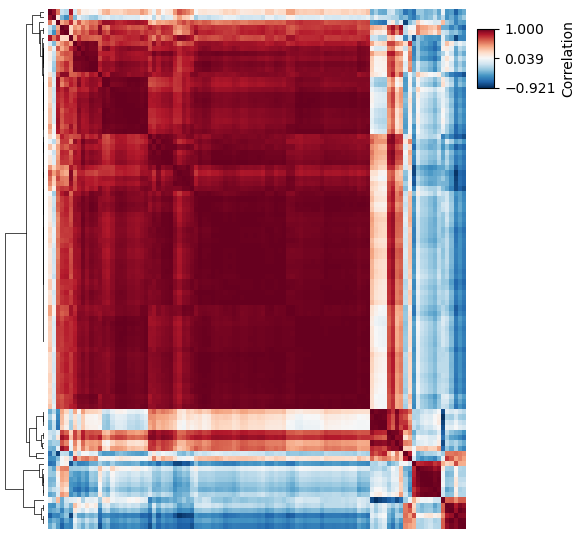

In [39]:
plt.figure(figsize=(6, 6))
cm = pch.ClusterMapPlotter(data=df_corr.iloc[0:100,0:100],
                            col_cluster=True,row_cluster=True, # cluster rows and dols
                            label='Correlation', # Legend Name
                            row_dendrogram=True,
                            show_rownames=False,show_colnames=False, # Do not show row or col names
                            cmap='RdBu_r', # set colors
                            verbose=0,
                            legend_gap = 10 # distance legend
                            #xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'} # rotate x axis marks
                            )

plt.savefig("example0.pdf", bbox_inches='tight')


In [8]:
import os,sys
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['font.family']='sans serif' #please remove this line if font is not installed
plt.rcParams['font.sans-serif']='Arial' # please remove this line if Arial font is not installed
plt.rcParams['pdf.fonttype']=42
# sys.path.append(os.path.expanduser("~/Projects/Github/PyComplexHeatmap/"))
import PyComplexHeatmap as pch
print(pch.__version__)

1.6.6


In [9]:
#Generate example dataset (random)
df = pd.DataFrame(['GroupA'] * 5 + ['GroupB'] * 5, columns=['AB'])
df['CD'] = ['C'] * 3 + ['D'] * 3 + ['G'] * 4
df['EF'] = ['E'] * 6 + ['F'] * 2 + ['H'] * 2
df['F'] = np.random.normal(0, 1, 10)
df.index = ['sample' + str(i) for i in range(1, df.shape[0] + 1)]
df.head()



,AB,CD,EF,F
sample1,GroupA,C,E,0.819864
sample2,GroupA,C,E,-1.936463
sample3,GroupA,C,E,0.654718
sample4,GroupA,D,E,0.033979
sample5,GroupA,D,E,0.164387


findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

Starting plotting HeatmapAnnotations


findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

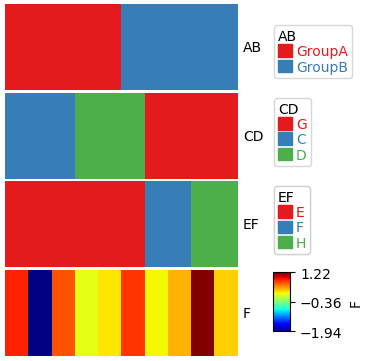

In [10]:
plt.figure(figsize=(3, 4))
col_ha = pch.HeatmapAnnotation(df=df,plot=True,legend=True,legend_gap=5,hgap=0.5,axis=1)
plt.show()

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

Starting plotting HeatmapAnnotations


findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

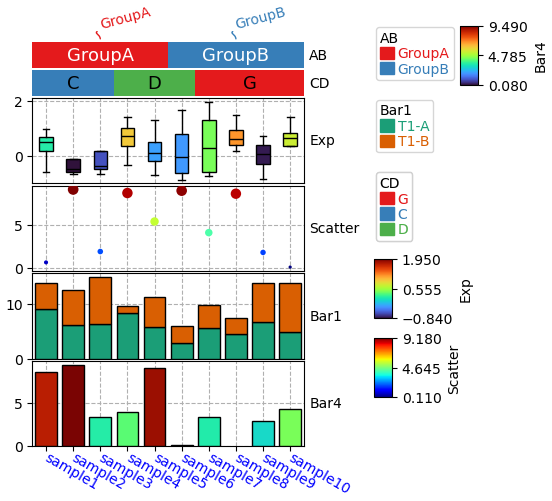

In [11]:
df_box = pd.DataFrame(np.random.randn(10, 4), columns=['Gene' + str(i) for i in range(1, 5)])
df_box.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_bar = pd.DataFrame(np.random.uniform(0, 10, (10, 2)), columns=['TMB1', 'TMB2'])
df_bar.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_scatter = pd.DataFrame(np.random.uniform(0, 10, 10), columns=['Scatter'])
df_scatter.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_bar1 = pd.DataFrame(np.random.uniform(0, 10, (10, 2)), columns=['T1-A', 'T1-B'])
df_bar1.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_bar4 = pd.DataFrame(np.random.uniform(0, 10, (10, 1)), columns=['T4'])
df_bar4.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_bar4.iloc[7,0]=np.nan

plt.figure(figsize=(3.5, 5))
col_ha = pch.HeatmapAnnotation(label=pch.anno_label(df.AB, merge=True,rotation=15),
                            AB=pch.anno_simple(df.AB,add_text=True,legend=True), axis=1,
                            CD=pch.anno_simple(df.CD, add_text=True,legend=True,text_kws={'color':'black'}),
                            Exp=pch.anno_boxplot(df_box, cmap='turbo',legend=True),
                            Scatter=pch.anno_scatterplot(df_scatter),
                           Bar1=pch.anno_barplot(df_bar1,legend=True,cmap='Dark2'),
                           Bar4=pch.anno_barplot(df_bar4,legend=True,cmap='turbo'),
                           plot=True,legend=True,legend_gap=5,hgap=0.5)
col_ha.show_ticklabels(df.index.tolist(),fontdict={'color':'blue'},rotation=-30)
plt.show()



findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

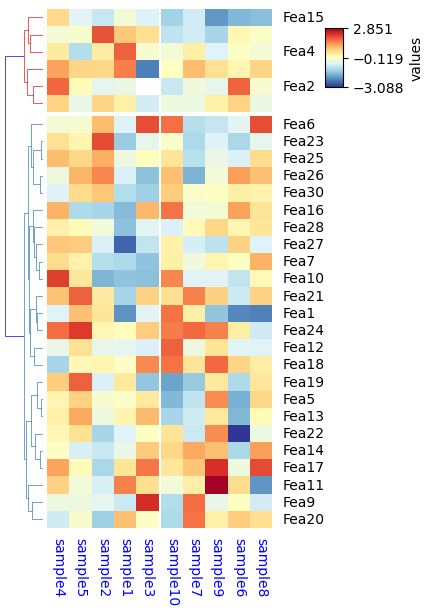

In [12]:
df_heatmap = pd.DataFrame(np.random.randn(30, 10), columns=['sample' + str(i) for i in range(1, 11)])
df_heatmap.index = ["Fea" + str(i) for i in range(1, df_heatmap.shape[0] + 1)]
df_heatmap.iloc[1, 2] = np.nan

plt.figure(figsize=(3.5, 6))
cm = pch.ClusterMapPlotter(data=df_heatmap,
                       col_cluster=True,row_cluster=True,
                       col_split=df.AB,row_split=2,
                       col_split_gap=0.5,row_split_gap=0.8,
                       label='values',row_dendrogram=True,
                       show_rownames=True,show_colnames=True,
                       row_names_side='right',
                       tree_kws={'row_cmap': 'Set1','colors':'blue'},verbose=0,legend_gap=5,
                       cmap='RdYlBu_r',xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'})
plt.savefig("example0.pdf", bbox_inches='tight')
plt.show()

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

Starting plotting HeatmapAnnotations


findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans serif' not found because

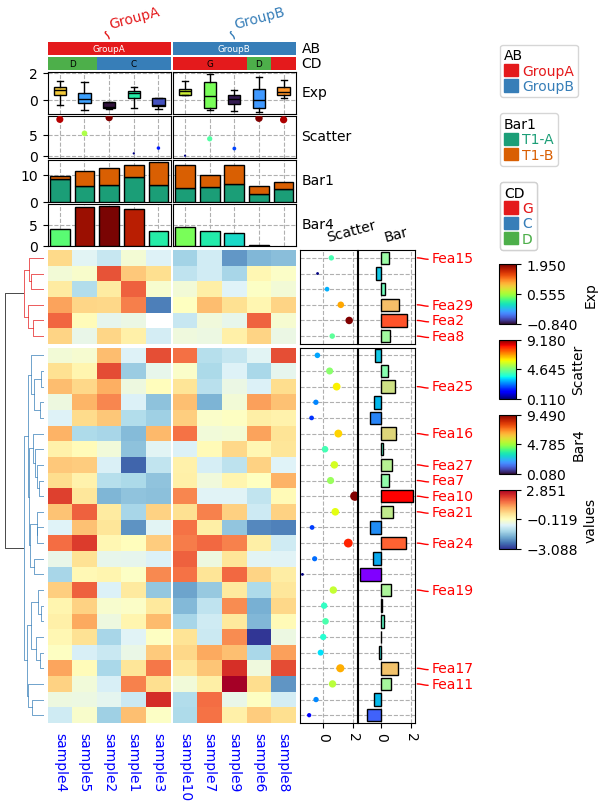

In [13]:
df_rows = df_heatmap.apply(lambda x:x.name if x.sample4 > 0.5 else None,axis=1)
df_rows=df_rows.to_frame(name='Selected')
df_rows['XY']=df_rows.index.to_series().apply(lambda x:'A' if int(x.replace('Fea',''))>=15 else 'B')

col_ha = pch.HeatmapAnnotation(label=pch.anno_label(df.AB, merge=True,rotation=15),
                            AB=pch.anno_simple(df.AB,add_text=True,legend=True), axis=1,
                            CD=pch.anno_simple(df.CD, add_text=True,legend=True,text_kws={'color':'black'}),
                            Exp=pch.anno_boxplot(df_box, cmap='turbo',legend=True),
                            Scatter=pch.anno_scatterplot(df_scatter),
                           Bar1=pch.anno_barplot(df_bar1,legend=True,cmap='Dark2'),
                           Bar4=pch.anno_barplot(df_bar4,legend=True,cmap='turbo'),
                           legend=True,legend_gap=5,hgap=0.5)

row_ha = pch.HeatmapAnnotation(
                           Scatter=pch.anno_scatterplot(df_heatmap.sample4.apply(lambda x:round(x,2)),
                                            height=15,cmap='jet',legend=False),
                           Bar=pch.anno_barplot(df_heatmap.sample4.apply(lambda x:round(x,2)),
                                            height=15,cmap='rainbow',legend=False),
                           selected=pch.anno_label(df_rows,colors='red',relpos=(-0.05,0.4)),
                           label_kws={'rotation':15,'horizontalalignment':'left','verticalalignment':'bottom'},
                            axis=0,verbose=0)

plt.figure(figsize=(5.5, 8))
cm = pch.ClusterMapPlotter(data=df_heatmap, top_annotation=col_ha,right_annotation=row_ha,
                       col_cluster=True,row_cluster=True,
                       col_split=df.AB,row_split=2,
                       col_split_gap=0.5,row_split_gap=0.8,
                       label='values',row_dendrogram=True,
                       show_rownames=False,show_colnames=True,
                       tree_kws={'row_cmap': 'Set1'},verbose=0,legend_gap=5,
                       cmap='RdYlBu_r',xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'})
plt.savefig("example0.pdf", bbox_inches='tight')
plt.show()

In [40]:
df_rows

,Selected,XY
Fea1,None,B
Fea2,Fea2,B
Fea3,None,B
Fea4,None,B
Fea5,None,B
Fea6,None,B
Fea7,Fea7,B
Fea8,Fea8,B
Fea9,None,B
Fea10,Fea10,B


In [44]:
plt.figure(figsize=(3, 4))
col_ha = pch.HeatmapAnnotation(label=pch.anno_label(df.AB, merge=True,rotation=15),
                            AB=pch.anno_simple(df.AB,add_text=True,legend=True), axis=1,
                            CD=pch.anno_simple(df.CD, add_text=True,legend=True,text_kws={'color':'black'}),
                            Exp=pch.anno_boxplot(df_box, cmap='turbo',legend=True),
                            Scatter=pch.anno_scatterplot(df_scatter),
                           Bar1=pch.anno_barplot(df_bar1,legend=True,cmap='Dark2'),
                           Bar4=pch.anno_barplot(df_bar4,legend=True,cmap='turbo'),
                           legend=True,legend_gap=5,hgap=0.5,plot=True)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'AB'

<Figure size 300x400 with 0 Axes>

# Bullk Sim Samples

In [ ]:
test = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/bulkSimulations/bootdev_feb20/1/simulated_bulk_datasets/brain_sc_with_metadata_cpm_pc/var_0.05_brain_sc_with_metadata_cpm_pc_simulated_bulk_samples.csv.gz", index_col = 0)
test.head()

In [ ]:
test_corr = test.T.corr()

In [ ]:
go_annot = pd.read_csv("/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024/data/processing/bp_annotations_withGeneData_qc_annotations.csv")

In [ ]:
brain_gos = curated_gos[curated_gos.loc[:,'BrainAffiliated'] =="T"]

In [ ]:
lo_brain_gos = brain_gos.id
lo_brain_gos

In [ ]:
test_go_term = "GO:0006836"
go_genes = go_annot[go_annot.loc[:,'GO ID'] == test_go_term].ensembl_gene_id

In [ ]:
go_term_gene_corrs = test_corr.iloc[test_corr.index.isin(go_genes), test_corr.index.isin(go_genes)]
go_term_gene_corrs


In [ ]:
go_term_gene_corrs.mean().mean()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt# Assuming you have a 2D dataset, for example, a correlation matrix

# Create a heatmap
sns.set(style="white")  # Optional: Set the background style
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Plot the heatmap using Seaborn's heatmap function
heatmap = sns.clustermap(go_term_gene_corrs, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)

# Remove x-axis and y-axis tick marks
heatmap.ax_heatmap.set_xticks([])
heatmap.ax_heatmap.set_yticks([])
plt.title("Heatmap Example")

# Show the plot
plt.show()


In [ ]:
non_go_term_gene_corrs = test_corr.iloc[~test_corr.index.isin(go_genes), ~test_corr.index.isin(go_genes)]

In [ ]:
non_go_term_gene_corrs.mean()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt# Assuming you have a 2D dataset, for example, a correlation matrix

# Create a heatmap
sns.set(style="white")  # Optional: Set the background style
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Plot the heatmap using Seaborn's heatmap function
heatmap = sns.heatmap(non_go_term_gene_corrs, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)

# Remove x-axis and y-axis tick marks
heatmap.ax_heatmap.set_xticks([])
heatmap.ax_heatmap.set_yticks([])
plt.title("Heatmap Example")

# Show the plot
plt.savefig('non_go_terms_corr_CELL_Bulk.png')


# CT Simulated Bulk

In [ ]:
df_corr_genes_in_go =  df_corr.iloc[df_corr.index.isin(go_genes),df_corr.index.isin(go_genes)]

In [ ]:
df_corr_genes_in_go.mean().mean()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt# Assuming you have a 2D dataset, for example, a correlation matrix

# Create a heatmap
sns.set(style="white")  # Optional: Set the background style
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Plot the heatmap using Seaborn's heatmap function
heatmap = sns.clustermap(df_corr_genes_in_go, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)

# Remove x-axis and y-axis tick marks
heatmap.ax_heatmap.set_xticks([])
heatmap.ax_heatmap.set_yticks([])
plt.title("Heatmap Example")

# Show the plot
plt.show()


In [ ]:
df_corr_genes_not_in_go =  df_corr.iloc[~df_corr.index.isin(go_genes),~df_corr.index.isin(go_genes)]
df_corr_genes_not_in_go

In [ ]:
df_corr_genes_not_in_go.mean().mean()

In [16]:
df_corr_genes_not_in_go.iloc[0:100,0:100]

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000005379,ENSG00000005381,ENSG00000005421,ENSG00000005436,ENSG00000005448,ENSG00000005469,ENSG00000005471,ENSG00000005483,ENSG00000005486,ENSG00000005513
ENSG00000000003,1.000000,-0.217412,-0.203734,-0.200691,-0.440572,-0.398527,-0.339447,-0.267607,-0.345377,-0.461779,...,0.062697,0.134909,0.979946,-0.203134,-0.201628,-0.140034,-0.339870,-0.283203,-0.171366,-0.362219
ENSG00000000005,-0.217412,1.000000,0.977173,0.964815,0.912685,-0.214603,-0.239157,0.990463,0.899308,0.944614,...,0.947227,0.924716,-0.400285,0.965133,0.963356,0.887079,0.657274,0.969307,0.998423,-0.161298
ENSG00000000419,-0.203734,0.977173,1.000000,0.998274,0.918206,-0.229182,-0.270407,0.949391,0.891392,0.959593,...,0.961503,0.940605,-0.382993,0.997464,0.998219,0.963235,0.505771,0.996220,0.980216,-0.019693
ENSG00000000457,-0.200691,0.964815,0.998274,1.000000,0.922377,-0.204088,-0.248761,0.930130,0.871154,0.954578,...,0.959000,0.938001,-0.379354,0.996339,0.999897,0.976662,0.477364,0.995324,0.968124,-0.003659
ENSG00000000460,-0.440572,0.912685,0.918206,0.922377,1.000000,0.161861,0.117449,0.877929,0.748301,0.930798,...,0.831291,0.788927,-0.608227,0.897341,0.918517,0.879793,0.668834,0.931640,0.895196,-0.134671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000005469,-0.140034,0.887079,0.963235,0.976662,0.879793,-0.181553,-0.237333,0.830148,0.788080,0.901004,...,0.929967,0.913452,-0.309756,0.967895,0.977271,1.000000,0.312538,0.960881,0.895239,0.089819
ENSG00000005471,-0.339870,0.657274,0.505771,0.477364,0.668834,0.300770,0.329966,0.682229,0.437651,0.532350,...,0.483597,0.447449,-0.466704,0.451219,0.468084,0.312538,1.000000,0.499943,0.625886,-0.659886
ENSG00000005483,-0.283203,0.969307,0.996220,0.995324,0.931640,-0.199792,-0.247330,0.945148,0.902588,0.978743,...,0.934143,0.907906,-0.455387,0.995457,0.995656,0.960881,0.499943,1.000000,0.969139,0.036088
ENSG00000005486,-0.171366,0.998423,0.980216,0.968124,0.895196,-0.257651,-0.281461,0.986995,0.901672,0.936136,...,0.960591,0.941796,-0.355530,0.970270,0.967037,0.895239,0.625886,0.969139,1.000000,-0.152576


In [33]:
import seaborn as sns
import matplotlib.pyplot as plt# Assuming you have a 2D dataset, for example, a correlation matrix

# Create a heatmap
sns.set(style="white")  # Optional: Set the background style
plt.figure(figsize=(8, 6))  # Optional: Set the figure size

# Plot the heatmap using Seaborn's heatmap function
heatmap = sns.clustermap(df_corr_genes_not_in_go, annot=False, cmap="coolwarm")

heatmap.ax_row_dendrogram.set_visible(False)
heatmap.ax_col_dendrogram.set_visible(False)


# Remove x-axis and y-axis tick marks
heatmap.ax_heatmap.set_xticks([])
heatmap.ax_heatmap.set_yticks([])

plt.title("Heatmap Example")
# Show the plot
plt.savefig('df_corr_genes_not_in_go_CTbulk.png')
plt.close()

/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/aadrian/miniforge3/envs/main_env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 800x600 with 0 Axes>

In [ ]:
results_for_test_go_term = melted_results[melted_results.loc[:,'index'] == test_go_term]
results_for_test_go_term

In [ ]:
results_for_test_go_term.groupby(['variance', 'exp_type', 'Tissue'])['auc'].mean() # Its pretty weird that the performance is decreasing beteen cntrl and exp.